## Imports

In [10]:
import numpy as np                 # linear algebra
import pandas as pd                # data processing
import matplotlib.pyplot as plt    # basic plotting library
import seaborn as sns              # more advanced visual plotting library

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers


## Data visualization
Import the MAGIC gamma telescope data 2004. Make sure that the file name and location is correct

In [11]:
headers = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "fClass"]
df = pd.read_csv('magic04.data', names=headers)
mapping = {'g': 1, 'h': 0}
df["fClass"] = df["fClass"].map(mapping)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  fClass    19020 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.6 MB


In [230]:
df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,fClass
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026,0.648370
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787,0.477492
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600,0.000000
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250,0.000000
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450,1.000000
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825,1.000000
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000,1.000000


In [231]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,fClass
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


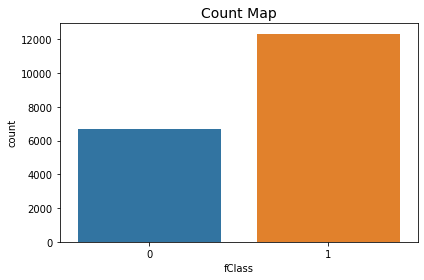

In [232]:
plt.figure()
sns.countplot(x="fClass", data=df)
plt.title("Count Map", fontsize=14)
plt.tight_layout()
plt.show()

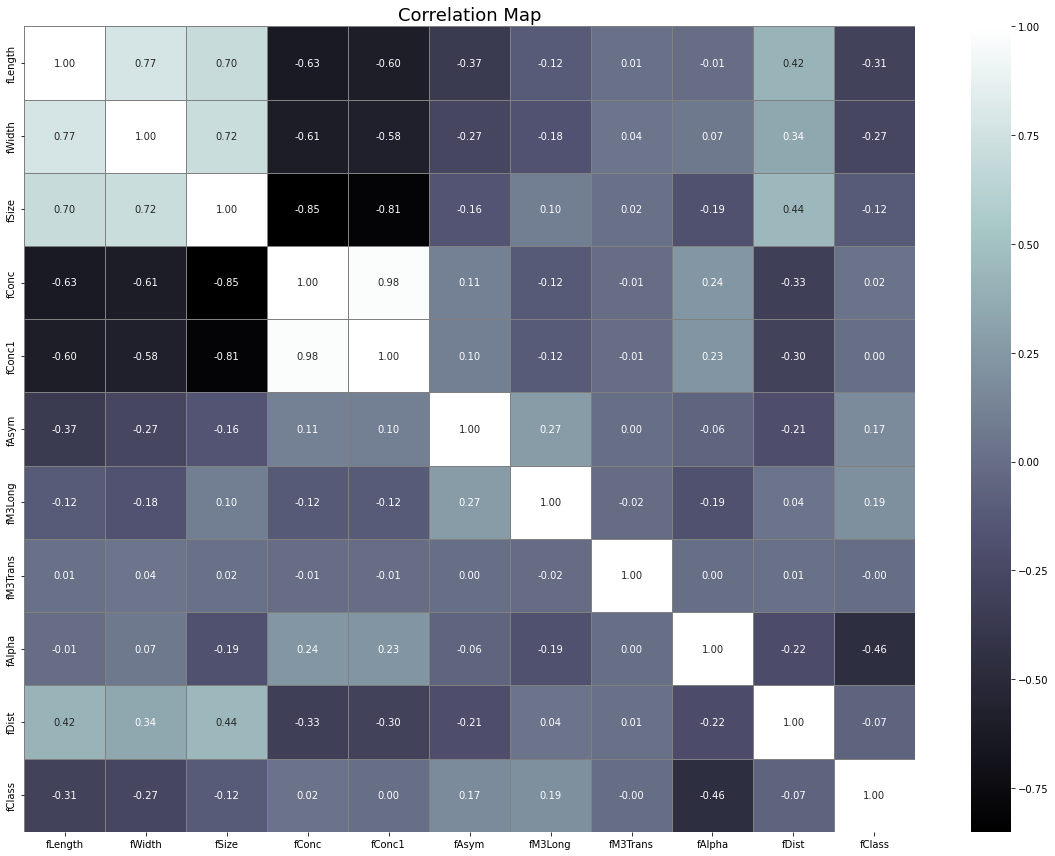

In [233]:
plt.figure(figsize=(16,12))
sns.heatmap(data=df.corr(), annot=True, cmap="bone", linewidths=1, fmt=".2f", linecolor="gray")
plt.title("Correlation Map", fontsize=18)
plt.tight_layout()
plt.show()

<Figure size 1152x864 with 0 Axes>

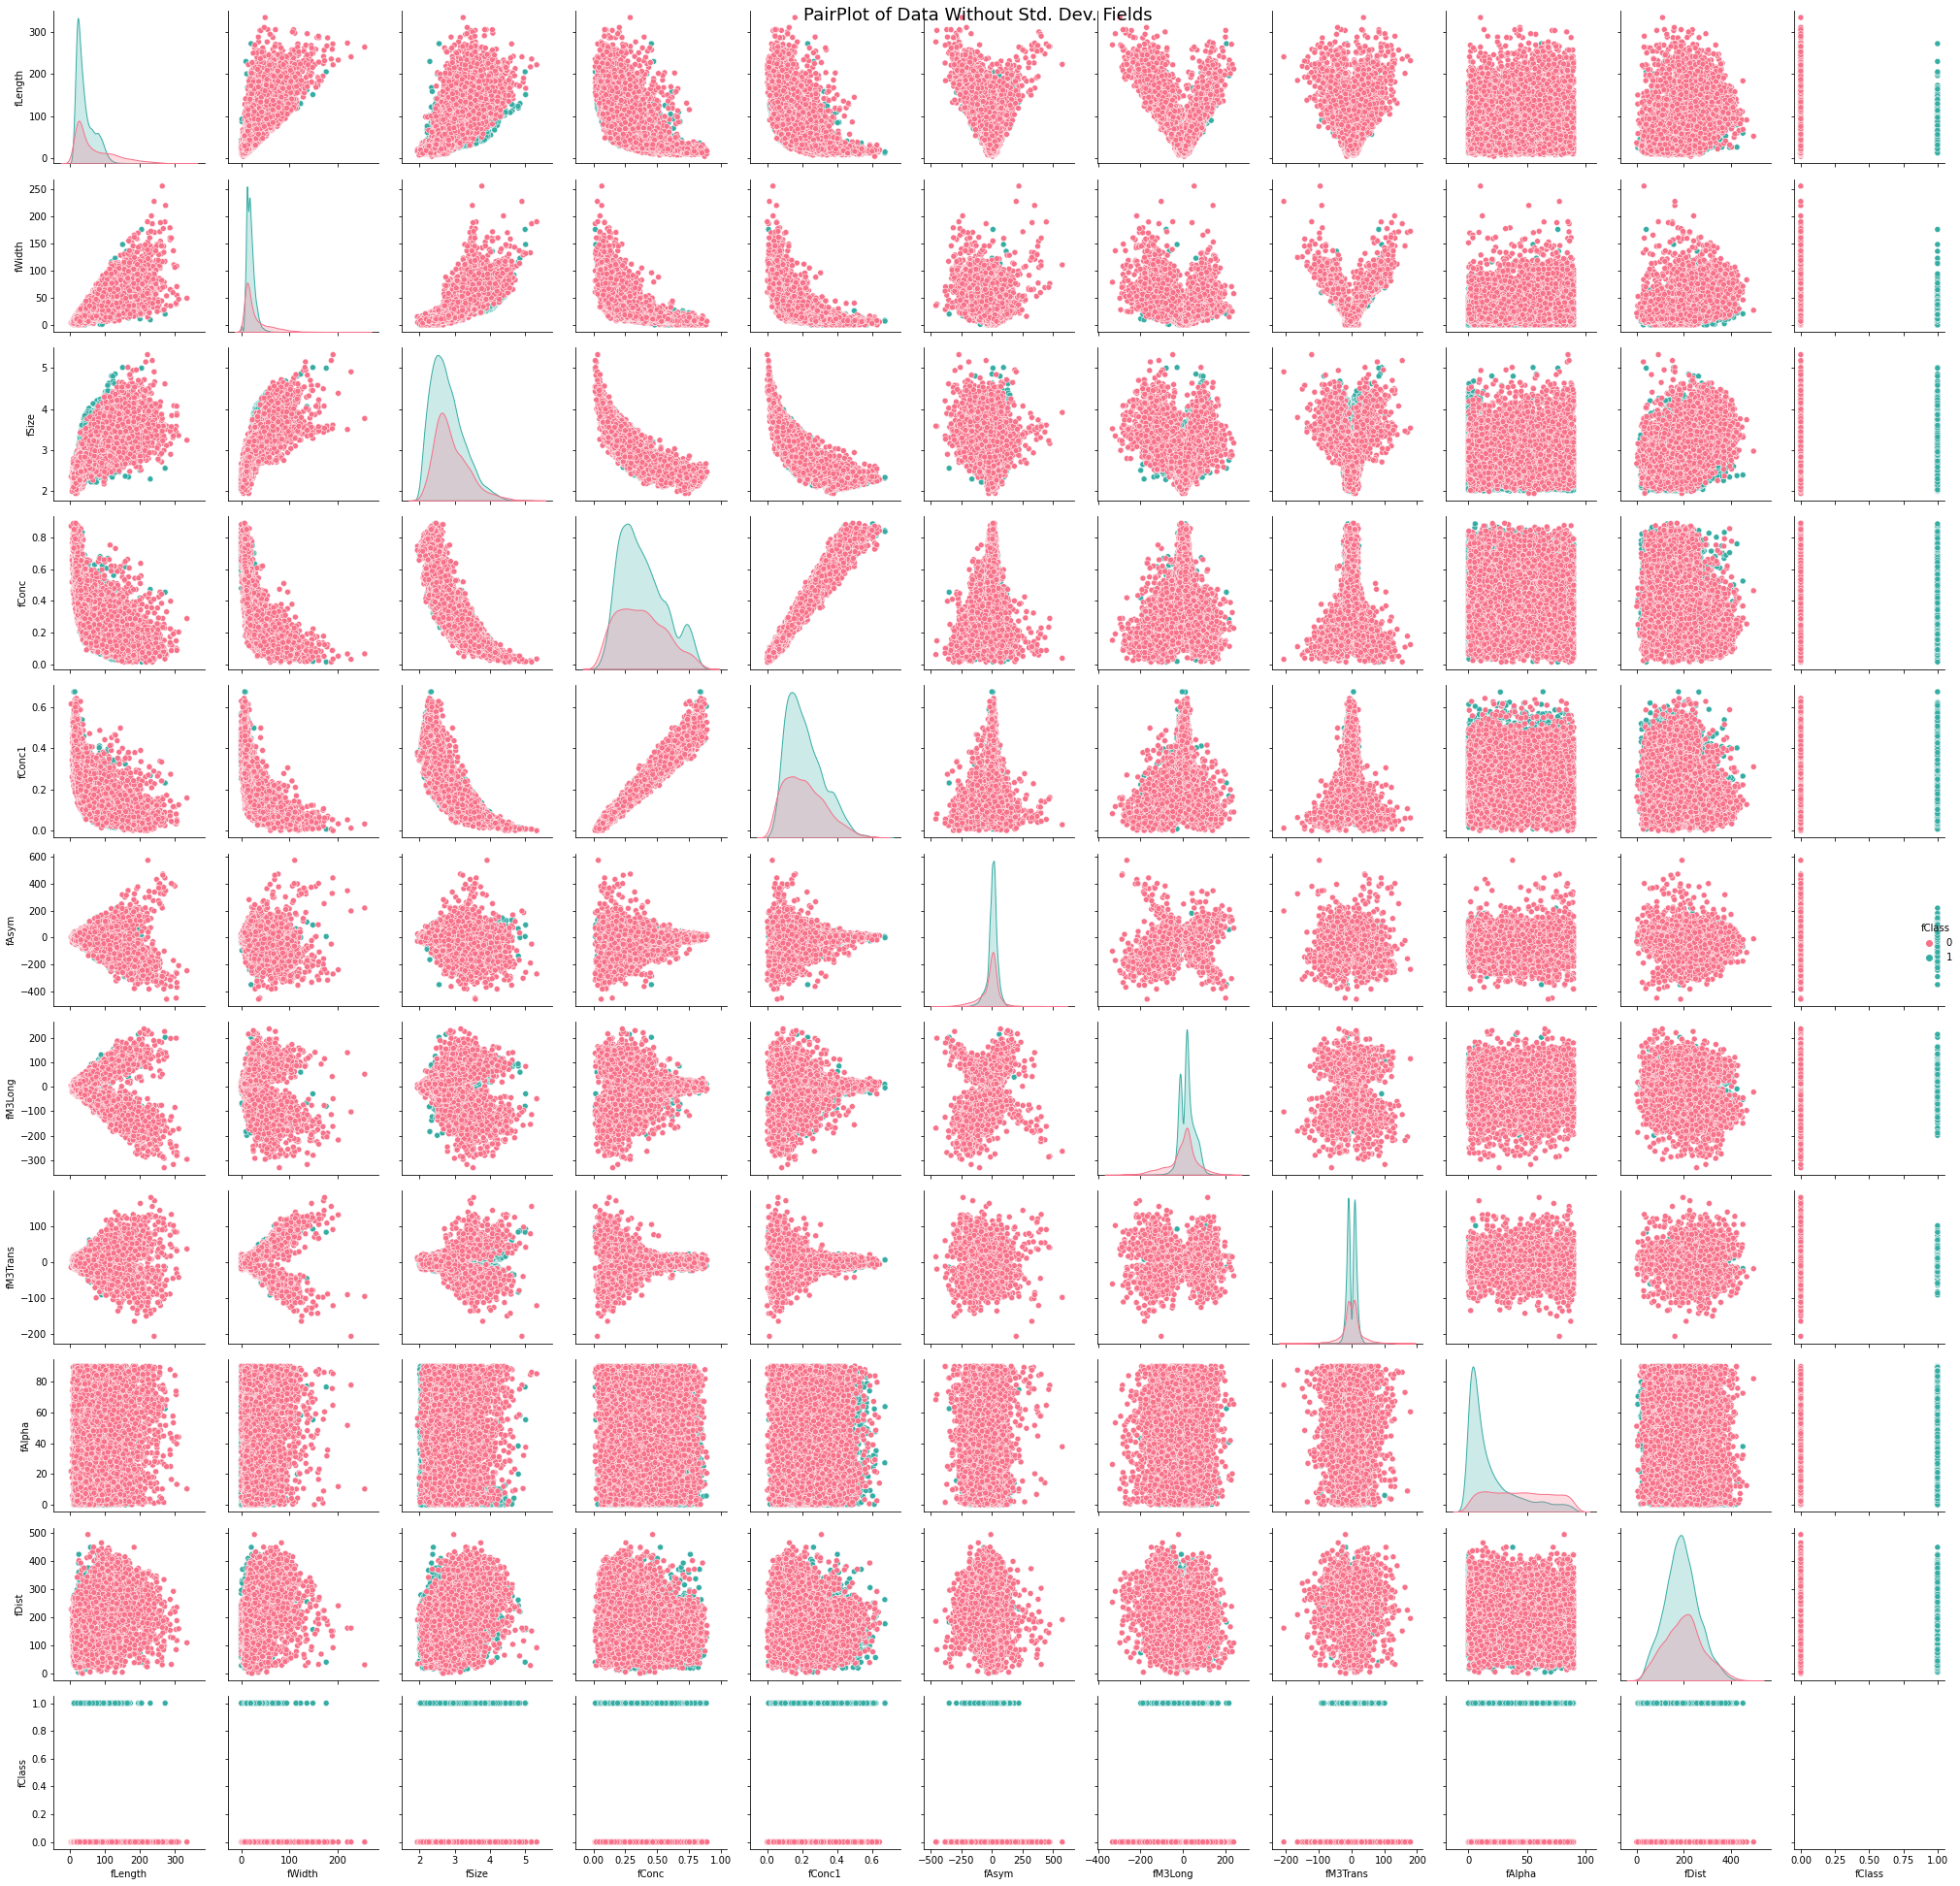

In [234]:
plt.figure(figsize=(16, 12))
sns.pairplot(data=df, palette="husl", hue="fClass", vars=headers)
plt.suptitle("PairPlot of Data Without Std. Dev. Fields", fontsize=18)
plt.tight_layout()
plt.show()

Count the amount of datapoints that have an extreme value, which could be an indicator for clipped data. Also makes a histogram of the width to get an idea of which fraction has 0 width, and a histogram of the elements with 0 width against their size.

5
4
0
0
98


array([[<AxesSubplot:title={'center':'fSize'}>]], dtype=object)

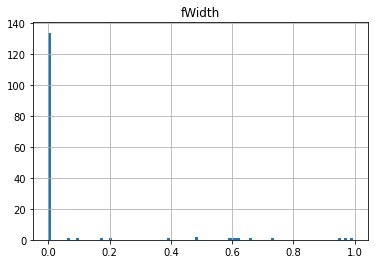

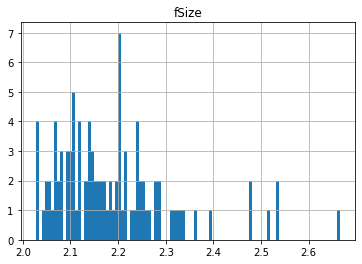

In [5]:
print(len(df[df['fAlpha'] == 0]))
print(len(df[df['fAlpha'] == 90]))
print(len(df[df['fSize'] == 0]))
print(len(df[df['fLength'] == 0]))
print(len(df[df['fWidth'] == 0]))
df[df['fWidth'] < 1].hist(column='fWidth', bins=100)
df[df['fWidth'] == 0].hist(column='fSize', bins=100)

## PCA
First PCA is performed on the whole set after which the explained variance per component is plotted. The explained variance shifts significantly towards the first 2 elements when using the minmax scaler instead of the standard scaler.

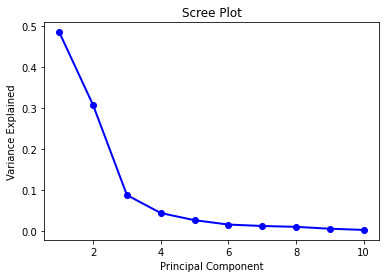

In [6]:
x = df.loc[:, headers[:-1]].values
y = df.loc[:, ['fClass']].values
# scaler = StandardScaler()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

pca = PCA()
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents)
finalDf = pd.concat([principalDf, df[['fClass']]], axis = 1)
finalDf.head()

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Calculate a PCA with only 2 components, and plot the dataset along those components. Using the minmax scaler shows that the data seperates significantly better, although there is still quite some data that overlaps.

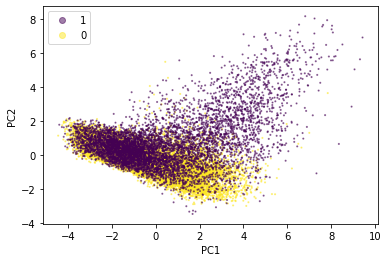

In [8]:
x = df.loc[:, headers[:-1]].values
y = df.loc[:, ['fClass']].values
scaler = StandardScaler()
# scaler = MinMaxScaler()
x = scaler.fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
finalDf = pd.concat([principalDf, df[['fClass']]], axis = 1)
finalDf.head()

plot = plt.scatter(finalDf['PC1'], finalDf['PC2'], c=y, s=5, alpha=0.5, marker='.')
plt.legend(handles=plot.legend_elements()[0], labels=list(['1', '0']))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Data pre-processing

create a second dataframe which has every feature except alpha divided by its corresponding size. This dataframe can be used as an alternative to classify. Furthermore, there is the choice for prescaling with the minmax scaler or the standard scaler. Lastly, a fischers linear discriminant analysis and a principal component analysis can be performed

In [12]:
df_rescaled = pd.DataFrame()
headers = ["fLength", "fWidth", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fDist","fAlpha", "fSize","fClass"]
rescaled_headers = [ "rescaled_length", "rescaled_width","rescaled_conc","rescaled_conc1"  ,"rescaled_asym","rescaled_M3long" ,"rescaled_M3trans","rescaled_dist" ,"alpha","size","rad"]
for i in range(0,8):
    df_rescaled.insert(i, rescaled_headers[i] ,df[headers[i]]/df["fSize"])
df_rescaled.insert(8, "alpha" ,df["fAlpha"])
df_rescaled.insert(9, "size" ,df["fSize"])
df_rescaled.insert(10, "rad" ,df["fClass"])
# df_rescaled.describe()

# df.drop(df[df.fWidth == 0].index, inplace=True) # Drops rows where fWidth == 0

y = df["fClass"].values

# # Drop everything but alpha
# todrop = ["fLength", "fWidth", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fDist", "fSize", "fClass"]

# # Only keep size, length, width and alpha
# todrop = ["fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fDist", "fClass"]

# Make sure to always drop the class column
todrop = ["fClass"]
x = df.drop(todrop, axis=1).values

# x = df_rescaled["rad"].values
# y = df_rescaled.drop(["rad"], axis=1).values

# Normalization
# scaler = StandardScaler()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# Fischers linear discriminant
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# model = LinearDiscriminantAnalysis()
# model.fit(x, y)
# x = model.transform(x)

# # PCA
# from sklearn.decomposition import PCA
# modelPCA = PCA(n_components=3)
# x = modelPCA.fit_transform(x) # project data on principal components

## Logistic Regression
Perform a logistic regression on the preprocessed data. The logistic regression is done a number of times and the obtained lr scores and roc scores are averaged.

In [13]:
lr_model = LogisticRegression(solver="sag", C=1, penalty="l2", max_iter=100)

lr_score = []
roc_score = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15)
    lr_model.fit(x_train, y_train)
    lr_score.append(lr_model.score(x_test, y_test))
    roc_score.append(roc_auc_score(y_test,lr_model.predict_proba(x_test)[:, 1]))
print("roc_score: ",np.mean(roc_score))
print("lr_score: ",np.mean(lr_score))


roc_score:  0.8407818055757902
lr_score:  0.79155275148966


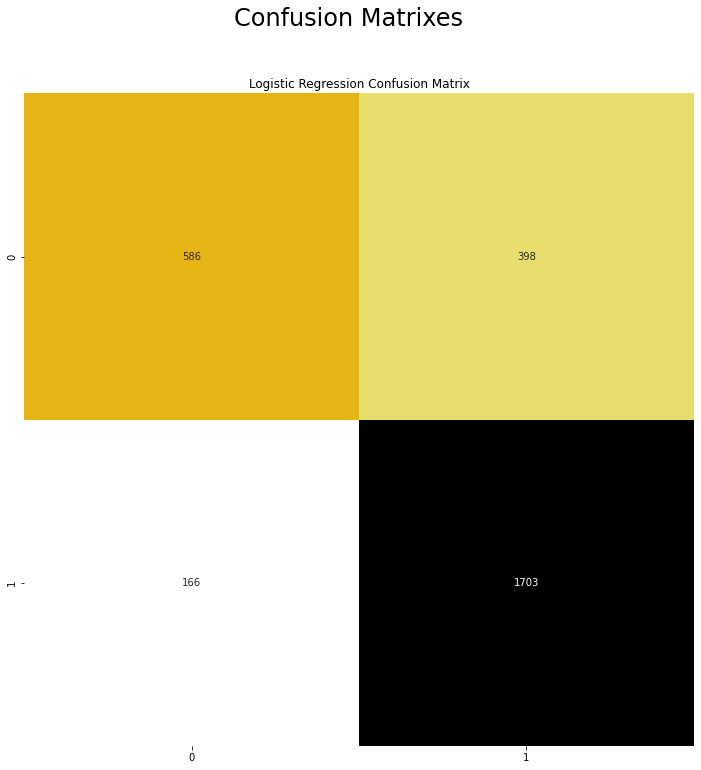

In [14]:

lr_pred=lr_model.predict(x_test)
cm_lr = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(cm_lr, cbar=False, annot=True, cmap="CMRmap_r", fmt="d")
plt.title("Logistic Regression Confusion Matrix")
plt.suptitle("Confusion Matrixes", fontsize=24)
plt.show()


## Deep Neural Network
Set up a DNN with 2 layers and relu activation, and run the DNN for 100 epochs

In [22]:
model = models.Sequential()
model.add(layers.Dense(1024, activation=tf.nn.relu, input_shape=(x.shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1024, activation=tf.nn.relu))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])

model.summary()

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15)

dnn_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              11264     
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,061,889
Trainable params: 1,061,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
162/162 [=======================

Calculate the final ROC score, plot the accuracy and the loss of the training data and the validation data per epoch, and plot the roc curve of the final model.

90/90 [==============================] - 0s 5ms/step - loss: 0.3115 - accuracy: 0.8763
roc score:  0.928591954799086


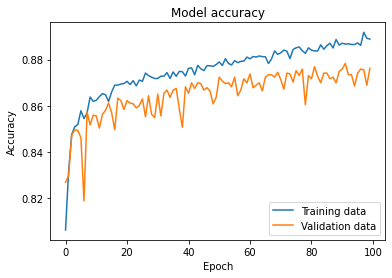

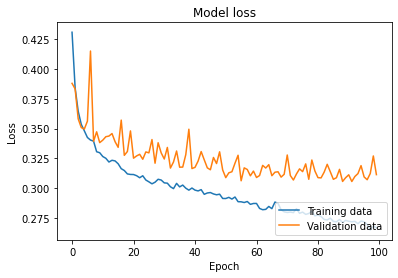

Text(0, 0.5, 'True Positive Rate')

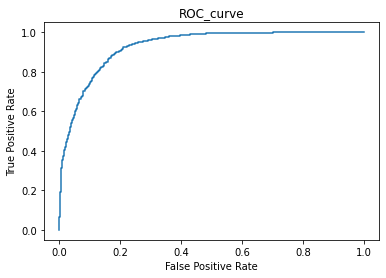

In [23]:
dnn_score = model.evaluate(x_test, y_test)
dnn_pred = model.predict(x_test)

from sklearn.metrics import roc_auc_score, roc_curve
roc_score = roc_auc_score(y_test, dnn_pred)
print("roc score: ", roc_score)

plt.plot(dnn_history.history['accuracy'])
plt.plot(dnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, dnn_pred)

plt.plot(fpr, tpr)
plt.title('ROC_curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')